In [40]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

plt.rcParams['font.family'] = 'Malgun Gothic'

In [41]:
df = pd.read_csv('./한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
df

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [42]:
df['시간'] = df['시간'] - 1
df

,연월일,시간,구분,공급량
0,2013-01-01,0,A,2497.129
1,2013-01-01,1,A,2363.265
2,2013-01-01,2,A,2258.505
3,2013-01-01,3,A,2243.969
4,2013-01-01,4,A,2344.105
...,...,...,...,...
368083,2018-12-31,19,H,681.033
368084,2018-12-31,20,H,669.961
368085,2018-12-31,21,H,657.941
368086,2018-12-31,22,H,610.953


In [43]:
# 한자리 정수로 표현된 시간 데이터 앞에 0 추가
df['시간'] = np.where(df['시간'] == 0, '00', df['시간'])
df['시간'] = np.where(df['시간'] == '1', '01', df['시간'])
df['시간'] = np.where(df['시간'] == '2', '02', df['시간'])
df['시간'] = np.where(df['시간'] == '3', '03', df['시간'])
df['시간'] = np.where(df['시간'] == '4', '04', df['시간'])
df['시간'] = np.where(df['시간'] == '5', '05', df['시간'])
df['시간'] = np.where(df['시간'] == '6', '06', df['시간'])
df['시간'] = np.where(df['시간'] == '7', '07', df['시간'])
df['시간'] = np.where(df['시간'] == '8', '08', df['시간'])
df['시간'] = np.where(df['시간'] == '9', '09', df['시간'])
df

,연월일,시간,구분,공급량
0,2013-01-01,00,A,2497.129
1,2013-01-01,01,A,2363.265
2,2013-01-01,02,A,2258.505
3,2013-01-01,03,A,2243.969
4,2013-01-01,04,A,2344.105
...,...,...,...,...
368083,2018-12-31,19,H,681.033
368084,2018-12-31,20,H,669.961
368085,2018-12-31,21,H,657.941
368086,2018-12-31,22,H,610.953


In [44]:
df['시점'] = df['연월일'].map(str) + ' ' + df['시간'].map(str)
df

,연월일,시간,구분,공급량,시점
0,2013-01-01,00,A,2497.129,2013-01-01 00
1,2013-01-01,01,A,2363.265,2013-01-01 01
2,2013-01-01,02,A,2258.505,2013-01-01 02
3,2013-01-01,03,A,2243.969,2013-01-01 03
4,2013-01-01,04,A,2344.105,2013-01-01 04
...,...,...,...,...,...
368083,2018-12-31,19,H,681.033,2018-12-31 19
368084,2018-12-31,20,H,669.961,2018-12-31 20
368085,2018-12-31,21,H,657.941,2018-12-31 21
368086,2018-12-31,22,H,610.953,2018-12-31 22


In [45]:
df['시점'] = pd.to_datetime(df['시점'], format='%Y-%m-%d %H')
df

,연월일,시간,구분,공급량,시점
0,2013-01-01,00,A,2497.129,2013-01-01 00:00:00
1,2013-01-01,01,A,2363.265,2013-01-01 01:00:00
2,2013-01-01,02,A,2258.505,2013-01-01 02:00:00
3,2013-01-01,03,A,2243.969,2013-01-01 03:00:00
4,2013-01-01,04,A,2344.105,2013-01-01 04:00:00
...,...,...,...,...,...
368083,2018-12-31,19,H,681.033,2018-12-31 19:00:00
368084,2018-12-31,20,H,669.961,2018-12-31 20:00:00
368085,2018-12-31,21,H,657.941,2018-12-31 21:00:00
368086,2018-12-31,22,H,610.953,2018-12-31 22:00:00


In [46]:
df.drop(columns=['연월일', '시간'], inplace=True)
df

,구분,공급량,시점
0,A,2497.129,2013-01-01 00:00:00
1,A,2363.265,2013-01-01 01:00:00
2,A,2258.505,2013-01-01 02:00:00
3,A,2243.969,2013-01-01 03:00:00
4,A,2344.105,2013-01-01 04:00:00
...,...,...,...
368083,H,681.033,2018-12-31 19:00:00
368084,H,669.961,2018-12-31 20:00:00
368085,H,657.941,2018-12-31 21:00:00
368086,H,610.953,2018-12-31 22:00:00


In [47]:
df.set_index('시점', inplace=True)
df

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


In [48]:
df_D = df[(df['구분'] == 'D')]
df_D.drop(columns='구분', inplace=True)
df_D

,공급량
시점,
2013-01-01 00:00:00,1434.516
2013-01-01 01:00:00,1345.636
2013-01-01 02:00:00,1270.756
2013-01-01 03:00:00,1322.036
2013-01-01 04:00:00,1421.956
...,...
2018-12-31 19:00:00,1835.411
2018-12-31 20:00:00,1767.964
2018-12-31 21:00:00,1720.595


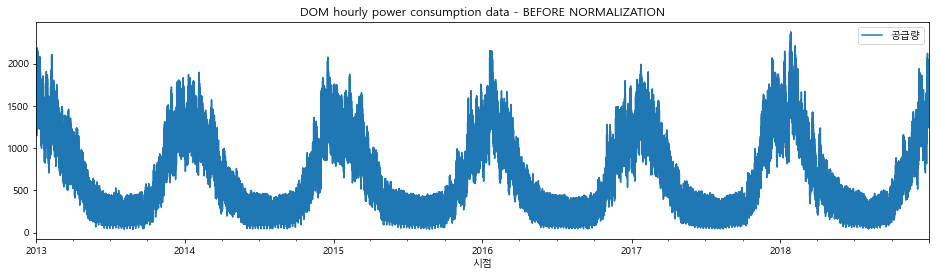

In [52]:
df_D.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [53]:
scaler = sklearn.preprocessing.MinMaxScaler()
df_D['공급량']=scaler.fit_transform(df_D['공급량'].values.reshape(-1,1))

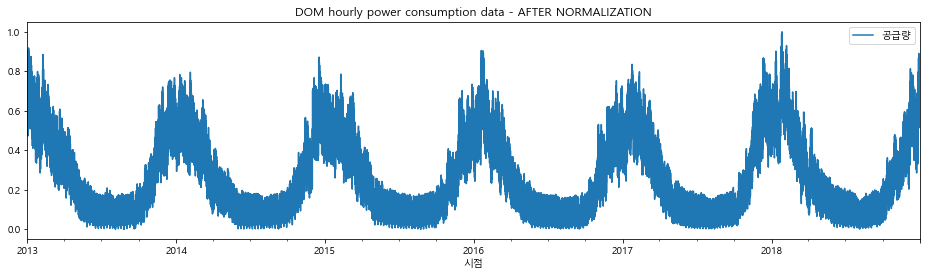

In [54]:
df_D.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [56]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[50000:]             
    y_test = y_train[50000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:50000]           
    y_train = y_train[:50000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (50000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
            
    return [X_train, y_train, X_test, y_test]

In [57]:
#create train, test data
seq_len = 24 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_D, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (50000, 24, 1)
y_train.shape =  (50000,)
X_test.shape =  (2560, 24, 1)
y_test.shape =  (2560,)


In [90]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))
    
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=20, batch_size=1000)
    
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
    
rnn_model.summary()

print("R2 Score of RNN model = ",rnn_score)

Epoch 1/20
50/50 [==============================] - 4s 49ms/step - loss: 0.1659
Epoch 2/20
50/50 [==============================] - 3s 51ms/step - loss: 0.0444
Epoch 3/20
50/50 [==============================] - 2s 48ms/step - loss: 0.0229
Epoch 4/20
50/50 [==============================] - 2s 48ms/step - loss: 0.0152
Epoch 5/20
50/50 [==============================] - 2s 50ms/step - loss: 0.0113
Epoch 6/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0088
Epoch 7/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0073
Epoch 8/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0064
Epoch 9/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0055
Epoch 10/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0049
Epoch 11/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0044
Epoch 12/20
50/50 [==============================] - 2s 49ms/step - loss: 0.0040
Epoch 13/20
50/50 [==================

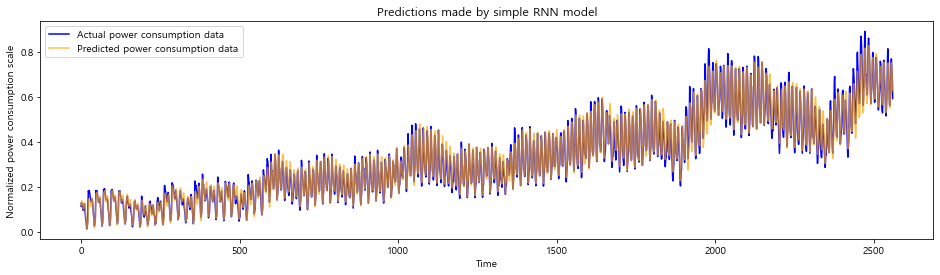

In [91]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [92]:
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [93]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [94]:
test.drop(columns='일자|시간|구분', inplace=True)

In [95]:
test['시간'] = test['시간'] - 1
test

,일자,시간,구분
0,2019-01-01,0,A
1,2019-01-01,1,A
2,2019-01-01,2,A
3,2019-01-01,3,A
4,2019-01-01,4,A
...,...,...,...
15115,2019-03-31,19,H
15116,2019-03-31,20,H
15117,2019-03-31,21,H
15118,2019-03-31,22,H


In [96]:
# 한자리 정수로 표현된 시간 데이터 앞에 0 추가
test['시간'] = np.where(test['시간'] == 0, '00', test['시간'])
test['시간'] = np.where(test['시간'] == '1', '01', test['시간'])
test['시간'] = np.where(test['시간'] == '2', '02', test['시간'])
test['시간'] = np.where(test['시간'] == '3', '03', test['시간'])
test['시간'] = np.where(test['시간'] == '4', '04', test['시간'])
test['시간'] = np.where(test['시간'] == '5', '05', test['시간'])
test['시간'] = np.where(test['시간'] == '6', '06', test['시간'])
test['시간'] = np.where(test['시간'] == '7', '07', test['시간'])
test['시간'] = np.where(test['시간'] == '8', '08', test['시간'])
test['시간'] = np.where(test['시간'] == '9', '09', test['시간'])
test

,일자,시간,구분
0,2019-01-01,00,A
1,2019-01-01,01,A
2,2019-01-01,02,A
3,2019-01-01,03,A
4,2019-01-01,04,A
...,...,...,...
15115,2019-03-31,19,H
15116,2019-03-31,20,H
15117,2019-03-31,21,H
15118,2019-03-31,22,H


In [97]:
test['시점'] = test['일자'].map(str) + ' ' + test['시간'].map(str)
test

,일자,시간,구분,시점
0,2019-01-01,00,A,2019-01-01 00
1,2019-01-01,01,A,2019-01-01 01
2,2019-01-01,02,A,2019-01-01 02
3,2019-01-01,03,A,2019-01-01 03
4,2019-01-01,04,A,2019-01-01 04
...,...,...,...,...
15115,2019-03-31,19,H,2019-03-31 19
15116,2019-03-31,20,H,2019-03-31 20
15117,2019-03-31,21,H,2019-03-31 21
15118,2019-03-31,22,H,2019-03-31 22


In [98]:
test['시점'] = pd.to_datetime(test['시점'], format='%Y-%m-%d %H')
test

,일자,시간,구분,시점
0,2019-01-01,00,A,2019-01-01 00:00:00
1,2019-01-01,01,A,2019-01-01 01:00:00
2,2019-01-01,02,A,2019-01-01 02:00:00
3,2019-01-01,03,A,2019-01-01 03:00:00
4,2019-01-01,04,A,2019-01-01 04:00:00
...,...,...,...,...
15115,2019-03-31,19,H,2019-03-31 19:00:00
15116,2019-03-31,20,H,2019-03-31 20:00:00
15117,2019-03-31,21,H,2019-03-31 21:00:00
15118,2019-03-31,22,H,2019-03-31 22:00:00


In [99]:
test.drop(columns=['일자', '시간'], inplace=True)
test

,구분,시점
0,A,2019-01-01 00:00:00
1,A,2019-01-01 01:00:00
2,A,2019-01-01 02:00:00
3,A,2019-01-01 03:00:00
4,A,2019-01-01 04:00:00
...,...,...
15115,H,2019-03-31 19:00:00
15116,H,2019-03-31 20:00:00
15117,H,2019-03-31 21:00:00
15118,H,2019-03-31 22:00:00


In [100]:
test.set_index('시점', inplace=True)
test

,구분
시점,
2019-01-01 00:00:00,A
2019-01-01 01:00:00,A
2019-01-01 02:00:00,A
2019-01-01 03:00:00,A
2019-01-01 04:00:00,A
...,...
2019-03-31 19:00:00,H
2019-03-31 20:00:00,H
2019-03-31 21:00:00,H


In [101]:
test_D = test[(test['구분'] == 'D')]
test_D.drop(columns='구분', inplace=True)
test_D

""
시점
2019-01-01 00:00:00
2019-01-01 01:00:00
2019-01-01 02:00:00
2019-01-01 03:00:00
2019-01-01 04:00:00
...
2019-03-31 19:00:00
2019-03-31 20:00:00
2019-03-31 21:00:00


In [102]:
test_D['공급량'] = np.nan
test_D

,공급량
시점,
2019-01-01 00:00:00,NaN
2019-01-01 01:00:00,NaN
2019-01-01 02:00:00,NaN
2019-01-01 03:00:00,NaN
2019-01-01 04:00:00,NaN
...,...
2019-03-31 19:00:00,NaN
2019-03-31 20:00:00,NaN
2019-03-31 21:00:00,NaN


In [103]:
D = df_D.append(test_D)
D

,공급량
시점,
2013-01-01 00:00:00,0.597218
2013-01-01 01:00:00,0.559258
2013-01-01 02:00:00,0.527277
2013-01-01 03:00:00,0.549179
2013-01-01 04:00:00,0.591854
...,...
2019-03-31 19:00:00,NaN
2019-03-31 20:00:00,NaN
2019-03-31 21:00:00,NaN


In [104]:
for i in range(len(test_D)):
    pred = rnn_model.predict(np.reshape(np.array(D.dropna()[len(D.dropna())-20:]), (1, 20, 1)))
    D.iloc[len(D.dropna())] = pred

D

,공급량
시점,
2013-01-01 00:00:00,0.597218
2013-01-01 01:00:00,0.559258
2013-01-01 02:00:00,0.527277
2013-01-01 03:00:00,0.549179
2013-01-01 04:00:00,0.591854
...,...
2019-03-31 19:00:00,0.164523
2019-03-31 20:00:00,0.164523
2019-03-31 21:00:00,0.164523


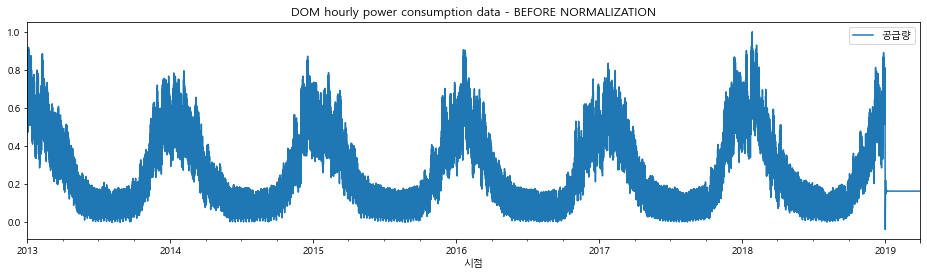

In [106]:
D.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [80]:
D0['공급량'] = scaler.inverse_transform(D0)
D0

,공급량
시점,
2013-01-01,1434.516000
2013-01-02,1291.316000
2013-01-03,1664.996000
2013-01-04,1688.276000
2013-01-05,1695.316000
...,...
2019-03-27,1334.996049
2019-03-28,1229.029178
2019-03-29,1298.368827


In [ ]:
for i in range(1,24):
    df_Dh = df[(df['구분'] == 'D') & (df.index.hour == i)]
    df_Dh.drop(columns='구분', inplace=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler()
    df_Dh['공급량']=scaler.fit_transform(df_Dh['공급량'].values.reshape(-1,1))
    
    X_train, y_train, X_test, y_test = load_data(df_Dh, seq_len)
    
    rnn_score = 0
    
    while rnn_score < 0.9:
        rnn_model = Sequential()

        rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
        rnn_model.add(Dropout(0.15))

        rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
        rnn_model.add(Dropout(0.15))

        rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
        rnn_model.add(Dropout(0.15))

        rnn_model.add(Dense(1))
    
        rnn_model.compile(optimizer="adam",loss="MSE")
        rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)
    
        rnn_predictions = rnn_model.predict(X_test)

        rnn_score = r2_score(y_test,rnn_predictions)
    
    test_Dh = test[(test['구분'] == 'D') & (test.index.hour == i)]
    test_Dh.drop(columns='구분', inplace=True)
    
    test_Dh['공급량'] = np.nan
    
    Dh = df_Dh.append(test_Dh)
    
    for j in range(len(test_Dh)):
        pred = rnn_model.predict(np.reshape(np.array(Dh.dropna()[len(Dh.dropna())-20:]), (1, 20, 1)))
        Dh.iloc[len(Dh.dropna())] = pred
        
    Dh['공급량'] = scaler.inverse_transform(Dh)
    
    D0 = D0.append(Dh)

Epoch 1/10
2/2 [==============================] - 1s 58ms/step - loss: 0.3524
Epoch 2/10
2/2 [==============================] - 0s 46ms/step - loss: 0.2178
Epoch 3/10
2/2 [==============================] - 0s 47ms/step - loss: 0.1486
Epoch 4/10
2/2 [==============================] - 0s 45ms/step - loss: 0.1627
Epoch 5/10
2/2 [==============================] - 0s 46ms/step - loss: 0.1157
Epoch 6/10
2/2 [==============================] - 0s 47ms/step - loss: 0.1048
Epoch 7/10
2/2 [==============================] - 0s 46ms/step - loss: 0.1119
Epoch 8/10
2/2 [==============================] - 0s 53ms/step - loss: 0.1045
Epoch 9/10
2/2 [==============================] - 0s 52ms/step - loss: 0.0826
Epoch 10/10
2/2 [==============================] - 0s 47ms/step - loss: 0.0781
Epoch 1/10
2/2 [==============================] - 1s 50ms/step - loss: 0.4387
Epoch 2/10
2/2 [==============================] - 0s 41ms/step - loss: 0.2574
Epoch 3/10
2/2 [==============================] - 0s 42ms/step 

In [37]:
D0

,공급량,시간
시점,,
2013-01-01 00:00:00,1434.516000,0
2013-01-02 00:00:00,1291.316000,0
2013-01-03 00:00:00,1664.996000,0
2013-01-04 00:00:00,1688.276000,0
2013-01-05 00:00:00,1695.316000,0
...,...,...
2019-03-27 23:00:00,-390.187215,23
2019-03-28 23:00:00,657.616701,23
2019-03-29 23:00:00,817.627588,23


In [38]:
D0 = D0.sort_index()
D0

,공급량,시간
시점,,
2013-01-01 00:00:00,1434.516000,0
2013-01-01 01:00:00,1345.636000,1
2013-01-01 02:00:00,1270.756000,2
2013-01-01 03:00:00,1322.036000,3
2013-01-01 04:00:00,1421.956000,4
...,...,...
2019-03-31 19:00:00,-2039.189601,19
2019-03-31 20:00:00,-327.478153,20
2019-03-31 21:00:00,1870.776866,21


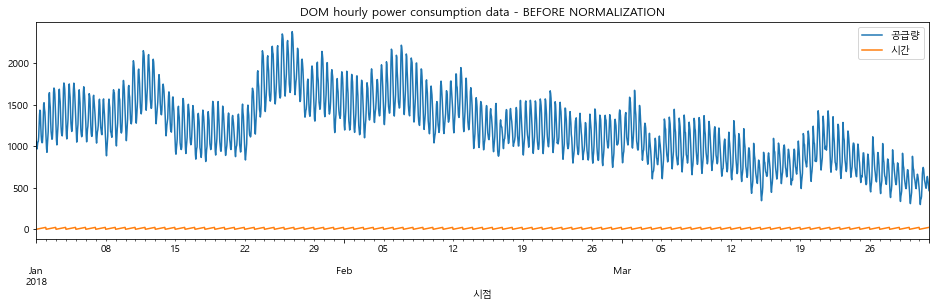

In [41]:
D0['2018-1-1':'2018-3-31'].plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [54]:
D0['2019-1-1':'2019-3-31'][D0['시간'] == 10]

,공급량,시간
시점,,
2019-01-01 10:00:00,1873.334639,10
2019-01-02 10:00:00,1840.933888,10
2019-01-03 10:00:00,1899.469963,10
2019-01-04 10:00:00,1956.602893,10
2019-01-05 10:00:00,1896.547916,10
...,...,...
2019-03-27 10:00:00,1268.107646,10
2019-03-28 10:00:00,29.272471,10
2019-03-29 10:00:00,183.369229,10


In [57]:
baseline = pd.read_csv('./baseline.csv')

In [58]:
baseline

,일자|시간|구분,공급량
0,2019-01-01 01 A,2021.909898
1,2019-01-01 02 A,1868.185928
2,2019-01-01 03 A,1795.530447
3,2019-01-01 04 A,1808.364544
4,2019-01-01 05 A,1997.302031
...,...,...
15115,2019-03-31 20 H,441.727074
15116,2019-03-31 21 H,436.862225
15117,2019-03-31 22 H,406.098589
15118,2019-03-31 23 H,344.833814


In [59]:
baseline['일자'] = baseline['일자|시간|구분'].str.split(' ').str[0]
baseline['시간'] = baseline['일자|시간|구분'].str.split(' ').str[1].astype(int)
baseline['구분'] = baseline['일자|시간|구분'].str.split(' ').str[2]

In [61]:
baseline.drop(columns='일자|시간|구분', inplace=True)

In [62]:
baseline['시간'] = baseline['시간'] - 1

In [63]:
baseline['시간'] = np.where(baseline['시간'] == 0, '00', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '1', '01', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '2', '02', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '3', '03', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '4', '04', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '5', '05', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '6', '06', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '7', '07', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '8', '08', baseline['시간'])
baseline['시간'] = np.where(baseline['시간'] == '9', '09', baseline['시간'])

In [64]:
baseline['시점'] = baseline['일자'].map(str) + ' ' + baseline['시간'].map(str)

In [67]:
baseline['시점'] = pd.to_datetime(baseline['시점'], format='%Y-%m-%d %H')

In [68]:
baseline.drop(columns=['일자', '시간'], inplace=True)

In [69]:
baseline.set_index('시점', inplace=True)

In [71]:
baseline_D = baseline[baseline['구분'] == 'D']

In [72]:
baseline_D

,공급량,구분
시점,,
2019-01-01 00:00:00,1306.761962,D
2019-01-01 01:00:00,1223.123623,D
2019-01-01 02:00:00,1157.743675,D
2019-01-01 03:00:00,1170.577772,D
2019-01-01 04:00:00,1270.637001,D
...,...,...
2019-03-31 19:00:00,1004.007210,D
2019-03-31 20:00:00,990.618582,D
2019-03-31 21:00:00,955.787428,D


In [74]:
df_D = df[df['구분'] == 'D']

In [77]:
df_D_ALL = df_D.append(baseline_D)
df_D_ALL

,구분,공급량
시점,,
2013-01-01 00:00:00,D,1434.516000
2013-01-01 01:00:00,D,1345.636000
2013-01-01 02:00:00,D,1270.756000
2013-01-01 03:00:00,D,1322.036000
2013-01-01 04:00:00,D,1421.956000
...,...,...
2019-03-31 19:00:00,D,1004.007210
2019-03-31 20:00:00,D,990.618582
2019-03-31 21:00:00,D,955.787428


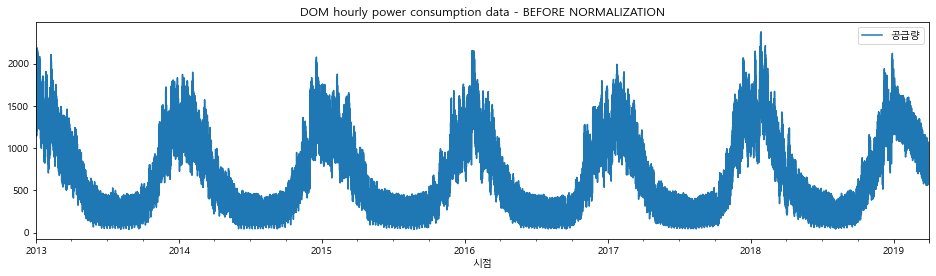

In [78]:
df_D_ALL.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()